In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Analyst/Datasets/AMD Historical Data.csv')
df1=df.reset_index()['Price']
len(df)

1611

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
print(train_size, test_size, val_size)

1127 322 162


In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [13]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 99ms/step - loss: 0.0215 - val_loss: 0.0089
Epoch 2/100
17/17 [==============================] - 1s 75ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 3/100
17/17 [==============================] - 1s 72ms/step - loss: 4.6694e-04 - val_loss: 0.0018
Epoch 4/100
17/17 [==============================] - 2s 92ms/step - loss: 2.6360e-04 - val_loss: 0.0016
Epoch 5/100
17/17 [==============================] - 1s 73ms/step - loss: 1.9284e-04 - val_loss: 0.0016
Epoch 6/100
17/17 [==============================] - 1s 72ms/step - loss: 1.8943e-04 - val_loss: 0.0022
Epoch 7/100
17/17 [==============================] - 1s 74ms/step - loss: 2.6514e-04 - val_loss: 0.0014
Epoch 8/100
17/17 [==============================] - 2s 113ms/step - loss: 1.7940e-04 - val_loss: 0.0015
Epoch 9/100
17/17 [==============================] - 2s 120ms/step - loss: 1.7999e-04 - val_loss: 0.0014
Epoch 10/100
17/17 [==============================] - 2s 91ms/step - l

In [15]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 16ms/step


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 91.56162080188642
Testing RMSE: 107.35583912796328


In [25]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps = 101
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.35759286 0.36179289 0.34650217 0.35719911 0.37872424 0.3840399
 0.39066807 0.40208689 0.4033994  0.4072713  0.400315   0.38180864
 0.39729623 0.43969025 0.4276808  0.42905893 0.43069957 0.43227458
 0.41291508 0.43063394 0.49291246 0.51699698 0.50242814 0.48661242
 0.50124688 0.49324058 0.48352802 0.47217483 0.48300302 0.50150938
 0.49645623 0.46298727 0.45261845 0.44126526 0.44021525 0.46082163
 0.44992781 0.45439034 0.45314346 0.45124032 0.46534978 0.47243733
 0.47007481 0.47630923 0.49770311 0.48890931 0.47998425 0.47565297
 0.5113532  0.52598766 0.57140045 0.579538   0.57277858 0.56700354
 0.57783174 0.5955506  0.58025988 0.57146607 0.55801286 0.56805355
 0.5798005  0.58065363 0.57113794 0.56660979 0.54488778 0.54429715
 0.5640504  0.55453472 0.5433784  0.54180339 0.53957212 0.52723455
 0.52664392 0.52769392 0.52880956 0.51778449 0.5121407  0.48739992
 0.50144376 0.51128757 0.52395327 0.52605329 0.52749705 0.47309358
 0.50584066 0.52703767 0.56116288 0.56129413 0.5741

In [27]:
x_input.shape

(1, 101, 1)

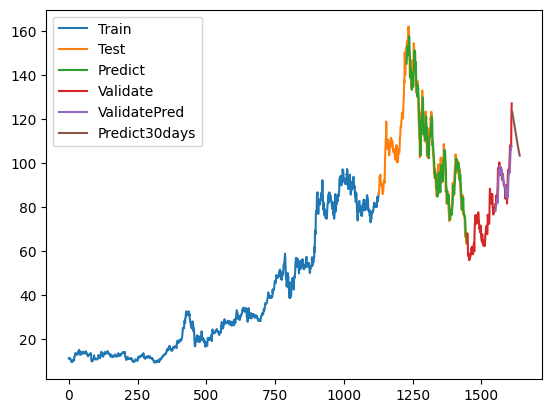

In [26]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()